# Credit Card Default Prediction
This notebook explores and cleans the dataset, performs feature engineering, and prepares data for modeling.


In [38]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# let the notebook know where to find the data
os.chdir("C:/Users/benla/Desktop/store_sales_forecasting")



In [39]:
# first we will load the data
df_train = pd.read_csv("data/raw/train.csv", header=0)

# check out the shape and head of the dataframe
print(f"df_train shape: {df_train.shape}")
print(f"df_train head:\n{df_train.head()}")

df_train shape: (3000888, 6)
df_train head:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


The next step is to perform EDA on the data

In [40]:
# # check to see that there are no missing values
# print(f"missing values:\n{df_train.isnull().sum()}")


# checking to see the general behavior of the data
df_train.info()
df_train.describe()


# # additional information to understand the dataset
# print('unique store numbers')
# print(df_train['store_nbr'].nunique())

# print('unique families')
# print(df_train['family'].nunique())

# print('sales averages')
# print(df_train['sales'].sum())

# print('unique dates')
# print(df_train['date'].nunique())



# df_train['date'] = pd.to_datetime(df_train['date']) # format it to the right date 
# daily_sales = df_train.groupby('date')['sales'].sum()
# daily_sales.plot(title='total sales over time') # the plot shows a relatively upward trending sales trajectory

# # see how often items get sold in general, and how often items in each family get sold.
# (df_train['sales'] == 0).mean()

# df_train.groupby('family')['sales'].apply(lambda x: (x==0).mean()).sort_values() # so it seems that there are a lot of categories that customers buy frequently and some that are not bought frequently at all


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [41]:
# after the initial basic EDA we will make a baseline model to see how well it can fit the data
features = (col for col in df_train.columns if col not in ['sales', 'date', 'id'])
x = df_train[features]
x = pd.get_dummies(x, columns=['family'], drop_first=True)
y = df_train['sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=305, shuffle=False)

# now make a model

model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=305
)



model.fit(x_train, y_train)

# 🔹 5. Make predictions and evaluate
y_pred = model.predict(x_test)
accuracy = model.score(x_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

# NEXT TIME DO RESEARCH ON THE DIFFERENT WAYS WE EVALUTATE MODELS LIKE ROC CURVES ETC.

# probably should add average store sales to the feature list

# how do i figure out which features should be added, given the context? is there something like a set checklist that can let me know if i am missing features?

# should I be adding the features first, or should i be making a really simple model first and then adding features later? how would i go about doing that? should i like add one feature at at ime, or add a bunch?

# how do i know which features are important? how do i know which features can be ignored/taken out?

# is the list of features that I should have changing with every model?


Model accuracy: 0.76


<Axes: >

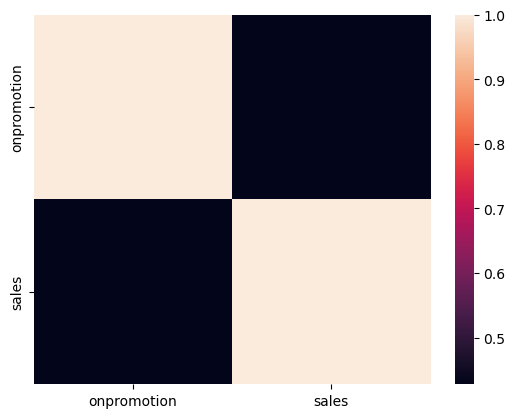

In [42]:
# correlation matrix
df_train_simplified = df_train[['onpromotion', 'sales']]
corr_matrix = df_train_simplified.corr()
sns.heatmap(corr_matrix)

# it seems like this will be hard to make a correlation matrix


In [43]:
# now see if there is any correlation between the features of the df
corr_matrix = df.corr()
strong_corr_matrix = corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)]
strong_corr_matrix

# now to see if there is any clear and strong correlation between the features and the labels
last_col = corr_matrix.iloc[-1]
last_col

sns.heatmap(df)
sns.heatmap(corr_matrix) # some of these are still not dummies 

NameError: name 'df' is not defined

After EDA is performed and we see that there is no simple correlation between the variables, we will now proceed to building predictive models

In [ ]:
# now, some of the columns have nomical categorical feature, and in this case we have to encode them into something that our model can more easily understand (unless we are using trees or something)
# for example, Marrital_status goes from 1 for married, 2 for single, and 3 for other. We want to turn this into 3 binary columns using one hot encoding

(24000, 24)
(24000,)
accuracy: 0.819
confusion matrix:
 [[4436  237]
 [ 849  478]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



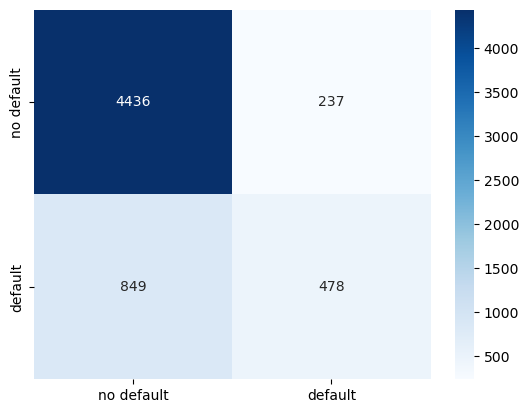

In [ ]:
# the first model that I want to build will be the xgboost since it will run without needing any further dummy variables/encodings, and can also deal with NANs (even though there are none in this case)



# the firs thing that I will have to do is make the target column y, and then drop it to make X
X = df.drop("default payment next month", axis=1)
y = df["default payment next month"]

# it is also good for me to test and make sure that there is some balance in the classes of y
y.value_counts() # 0 -> 23364, 1-> 6636
# since this is relatively unbalanced, this means that I should stratify to make sure that we are balanced

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)

# now that we have split the testing and training data, it is time to make the actual models.
model = XGBClassifier(
    n_estimators = 100,
    max_depth = 3,
    learning_rate=0.1,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('accuracy:', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix:\n', cm)
labels = ['no default', 'default']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

print(classification_report(y_test, y_pred))